### Setup

In [1]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee
from components import *

%matplotlib inline

No display found. Using non-interactive Agg backend.


In [2]:
min_freq = 0.5e9
max_freq = 2.9e9 #Needs to be less than 3ghz for amplifier data

freq = rf.frequency.Frequency(start=min_freq/1e9, stop=max_freq/1e9, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 290


# Measured circulator s params

s_circ_db = np.array([[-22,-0.8,-0.8],
                        [-30,-22,-0.8],
                        [-31,-25,-21]])

### Making Circuit

In [9]:
def make_circuits_variable_leakage(leakage,reflection,cav_temp,termi_temp,cav_r=2000,):

    #Amplifier
    #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(AMP_PATH,AMP_NAME,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam
    
    # Cables
    
    LEN_CABLE = 0.01 #m
    noisy_ntw_cable = make_coax_cable('RG405U',freq,LEN_CABLE,Troom)

    #Cavity

    freq_cavity = 2.027e9 # Measured
    R_cavity= cav_r # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 163.9 # Measured

    start_freq = min_freq
    stop_freq = max_freq

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, cav_temp)

    #Circulator 
    ntw_circ_1 = create_circulator_variable_leakage(freq,leakage,reflection) # <- f-n params
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    termi_gamma = db_to_power_ratio(-26.6) # measured
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=termi_gamma)
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    noisy_ntw_termi_cold = read_in_noisy_network(ntw_termi_1, freq, termi_temp)
    
    def make_blue_circuit_amps():
        # Circuit diagram

        # (SA) - amps - 1 - [circ] - 3 - 1 [cavity] 2 - 1 [termi1]
        #                     2
        #                     |
        #                  [termi2]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',3)
        mnns.connect('termi2',1,'circ',2)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)
       
        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit_amps_cold_termi():
        # Circuit diagram

        # (SA) - amps - 1 - [circ] - 3 - 1 [cavity] 2 - 1 [termi1]
        #                     2
        #                     |
        #                  [termi cold]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_cold,'termi_cold')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',3)
        mnns.connect('termi_cold',1,'circ',2)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)
       
        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 3 - 1 [cavity] 2 - 1 [termi1]
        #              2
        #              |
        #           [termi2]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',3)
        mnns.connect('termi2',1,'circ',2)
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit_cold_termi():
        # Circuit diagram

        # (SA) - 1 - [circ] - 3 - 1 [cavity] 2 - 1 [termi1]
        #              2
        #              |
        #           [termi cold]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_cold,'termi_cold')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',3)
        mnns.connect('termi_cold',1,'circ',2)
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns

        
    # Create circuits
    blue_circuit_amps = make_blue_circuit_amps()
    blue_circuit_amps_cold_termi = make_blue_circuit_amps_cold_termi()
    blue_circuit = make_blue_circuit()
    blue_circuit_cold_termi = make_blue_circuit_cold_termi()
    
    # return dictionary for plotting
    
    ntw_dict = {'blue': blue_circuit,'blue_cold_termi': blue_circuit_cold_termi,'blue_amps': blue_circuit_amps,'blue_amps_cold_termi': \
                blue_circuit_amps_cold_termi}
    
    return ntw_dict
        
    

### Noise temp plots for blue circuit with and without amplifiers 
(measured leakage and reflection)

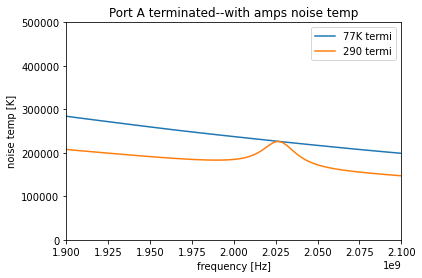

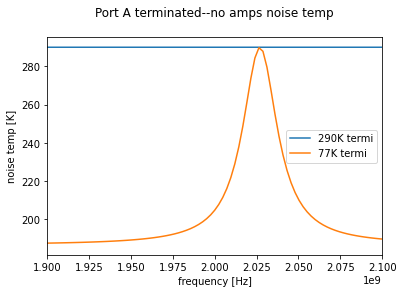

In [51]:

cav_temp=290; termi_temp=77
leakage= -30; reflection= -22; cav_r=2000

ntw_dict = make_circuits_variable_leakage(leakage,reflection,cav_temp,termi_temp,cav_r)
blue_circuit_amps = ntw_dict['blue_amps']
blue_circuit_amps_cold_termi = ntw_dict['blue_amps_cold_termi']
blue_circuit = ntw_dict['blue']
blue_circuit_cold_termi = ntw_dict['blue_cold_termi']

blue_circuit_temp = np.abs(blue_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit.s[:,0,0]**2) )
blue_circuit_amps_temp = np.abs(blue_circuit_amps.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps.s[:,0,0]**2) )
blue_circuit_amps_cold_termi_temp = np.abs(blue_circuit_amps_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps_cold_termi.s[:,0,0]**2) )
blue_circuit_cold_termi_temp = np.abs(blue_circuit_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_cold_termi.s[:,0,0]**2) )


# Blue circuit-- with amps plot
plt.plot( freq.f, blue_circuit_amps_temp, label = f'{termi_temp}K termi' )
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]'); plt.title('Port A terminated--with amps noise temp'); 

plt.plot( freq.f, blue_circuit_amps_cold_termi_temp, label =f'{cav_temp} termi' );plt.xlim(1.9e9,2.1e9);plt.ylim(0,.5e6)
plt.legend();plt.show()

# Blue circuit-- no amps plot
plt.plot( freq.f, blue_circuit_temp, label = f'{cav_temp}K termi' );plt.xlim(1.9e9,2.1e9)
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]');plt.title('Port A terminated--no amps noise temp\n'); 

plt.plot( freq.f, blue_circuit_cold_termi_temp, label =f'{termi_temp}K termi' )
plt.legend(); plt.show() 

### Plots for changing cavity temperature

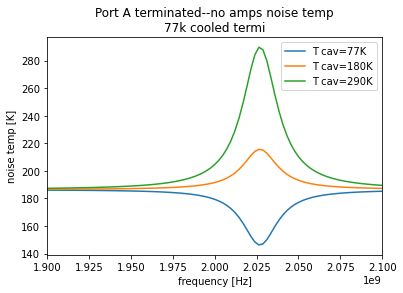

In [50]:
### create figure with series of different cavity temperatures

# termi_temp -> temp of cooled terminator

cav_temp_list = np.array([77,180,290])

def make_cav_temp_plots(cav_temp_list):
    
    fig, ax2 = plt.subplots(1,1)
    
    for cav_temp in cav_temp_list:

        ntw_dict = make_circuits_variable_leakage(leakage,reflection,cav_temp,termi_temp,cav_r)
        blue_circuit_amps = ntw_dict['blue_amps']
        blue_circuit_amps_cold_termi = ntw_dict['blue_amps_cold_termi']
        blue_circuit = ntw_dict['blue']
        blue_circuit_cold_termi = ntw_dict['blue_cold_termi']

        blue_circuit_temp = np.abs(blue_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit.s[:,0,0]**2) )
        blue_circuit_amps_temp = np.abs(blue_circuit_amps.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps.s[:,0,0]**2) )
        blue_circuit_amps_cold_termi_temp = np.abs(blue_circuit_amps_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps_cold_termi.s[:,0,0]**2) )
        blue_circuit_cold_termi_temp = np.abs(blue_circuit_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_cold_termi.s[:,0,0]**2) )


    #     # Blue circuit-- with amps plot
    #     ax1.plot( freq.f, blue_circuit_amps_temp, label = f'{Troom}K termi' )
    #     ax1.set_xlabel('frequency [Hz]'); ax1.set_ylabel('noise temp [K]'); ax1.set_title('Port A terminated--with amps noise temp'); 

    #     ax1.plot( freq.f, blue_circuit_amps_cold_termi_temp, label =f'{cav_temp} termi' );ax1.set_xlim(1.9e9,2.1e9);ax1.set_ylim(0,.5e6)
    #     ax1.legend();

        # Blue circuit-- no amps plot
        # ax2.plot( freq.f, blue_circuit_temp, label = f'{Troom}K termi' );ax2.set_xlim(1.9e9,2.1e9)
        
    
        ax2.set_xlabel('frequency [Hz]'); ax2.set_ylabel('noise temp [K]');ax2.set_title(f'Port A terminated--no amps noise temp\n77k cooled termi'); 
        ax2.set_xlim(1.9e9,2.1e9)
        ax2.plot( freq.f, blue_circuit_cold_termi_temp, label =f'T cav={cav_temp}K' )
        ax2.legend(); 
        
    plt.show()
        
make_cav_temp_plots(cav_temp_list)

### Finding smallest change in temperature visible

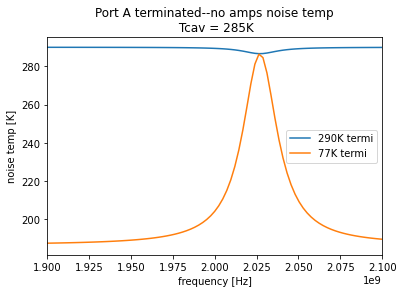

In [42]:
make_cav_temp_plots(np.array([285]))

### Noise temp using Qports cavity network